In [11]:
import math
import random

In [87]:
class Value:
    def __init__(self, data, label='', _op='', _children=()):
        self.data = data
        self._op = _op
        self._prev = set(_children)
        self.label = label
        self.grad = 0.0
        self._backward = lambda: None
        
        
    def __repr__(self) :
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        if not isinstance(other, Value):
            other = Value(other)
        out = Value(self.data + other.data, _op='+', _children=(self, other))
        def _backward():
            self.grad += 1.0 * out.grad 
            other.grad += 1.0 * out.grad
        
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        if not isinstance(other, Value):
            other = Value(other)
        out = Value(self.data * other.data, _op='*', _children=(self, other))
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self, other) :
        return self*other
    
    def tanh(self):
        out = Value(math.tanh(self.data), _children=(self, ), _op='tanh')
        def _backward():
            self.grad += 1 - (out.data**2)
        out._backward = _backward
        return out
    
    def exp(self):
        out = Value(math.exp(self.data), _children=(self, ), _op='exp')
        def _backward():
            self.grad += out.data
        out._backward = _backward
        return out
        
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        rev_topo = list(reversed(topo))
        for node in rev_topo:
            node._backward()

In [88]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [89]:
a = Value(.5, 'a')
b = Value(1.0, 'c')
c = a + b; c.label = 'c'
d = Value(0.2, 'd')
L = c * d; L.label = "L"
#Ltan = L.tanh(); Ltan.label="ltan"
Lexp = L.exp(); Lexp.label="Lexp"
Lexp.backward()

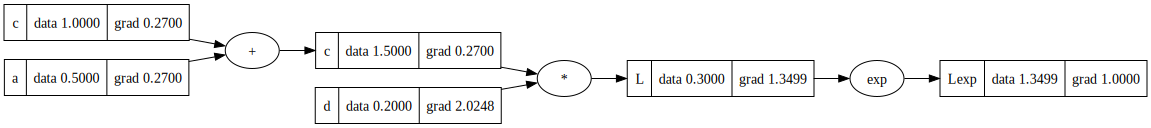

In [90]:
draw_dot(Lexp)

## Single neuron

In [117]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
    
    def __call__(self, x):
        #w*x +b
        act = Value(0.0)
        print(type(act))
        for wi, xi in zip (self.w, x):
            act += wi*xi
        #act = sum(wi*xi for wi, xi in zip(self.w, x)) + self.b
        act += self.b
        out = act.tanh()
        return out
        return out
    
    def parameters(self):
        return (self.w + [self.b])

## Layer of Neurons

In [118]:
class Layer:
    def __init__(self, ninp, nout):
        self.neurons = [Neuron(ninp) for i in range(nout)]
    
    
    def __call__(self, X):
        outs = [n(X) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
            return [p for neuron in self.neurons for p in neuron.parameters()]
            

## Multi-layer perceptron

In [119]:
class MLP:
    def __init__(self, ninp = 3):
        self.layers=[]
        self.layer1 = Layer(ninp, 3)
        self.layers.append(self.layer1)
        self.layer2 = Layer(3,4)
        self.layers.append(self.layer2)
        self.layer3 = Layer(4, 3)
        self.layers.append(self.layer3)
        self.layer4 = Layer(3, 1)
        self.layers.append(self.layer4)
    
    def __call__(self, X):
        out1 = self.layer1(X)
        out2 = self.layer2(out1)
        out3 = self.layer3(out2)
        out4 = self.layer4(out3)
        return out4
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
        

In [120]:
X = [2.0 , 3.0, 4.0]

[Value(data=-0.8465315680076906), Value(data=-0.37369472509746604), Value(data=0.6739064395168166), Value(data=0.7842174929461216)]
<class '__main__.Value'>


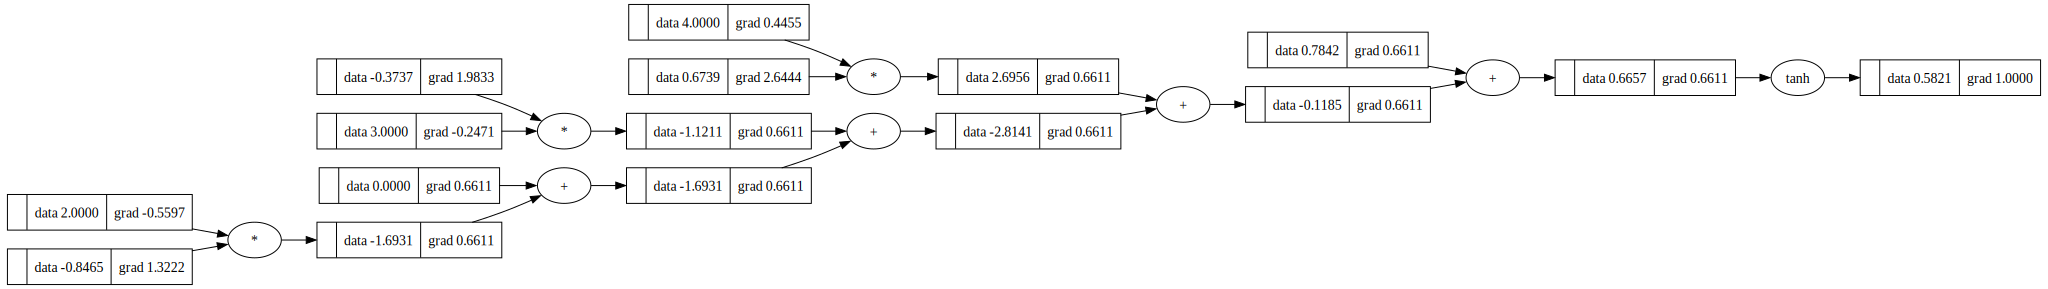

In [131]:
test = Neuron(3)
print(test.parameters())
out = test(X)
out.backward()
draw_dot(out)

In [132]:
test1 = Layer(3, 2)
#print(test1.parameters())
out = test1(X)
print(test1.parameters())
draw_dot(out)

<class '__main__.Value'>
<class '__main__.Value'>
[Value(data=0.38469205944088425), Value(data=-0.8441076473728968), Value(data=-0.19216555946530223), Value(data=-0.2312350535984986), Value(data=-0.7288539362287134), Value(data=0.141190571081254), Value(data=-0.09390562415209525), Value(data=0.5086632028890117)]


TypeError: unhashable type: 'list'